In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/NalaiyaThiran/Dataset/Veg-dataset.zip")
zip_ref.extractall()
zip_ref.close()


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import random
import cv2
from tensorflow.keras import layers, models
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import pickle
import zipfile
tf.__version__

'2.9.2'

In [5]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
batch_size = 32
IMAGE_SIZE = [128, 128]
EPOCHS = 25

In [7]:
TRAIN_PATH = "/content/Veg-dataset/train_set"

VEG_TRAIN_CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(TRAIN_PATH + "*/*"))])
VEG_TRAIN_CLASS_NAMES

array(['Tomato___Bacterial_spot', 'Tomato___Late_blight',
       'Pepper,_bell___healthy', 'Tomato___Leaf_Mold',
       'Potato___Early_blight', 'Tomato___Septoria_leaf_spot',
       'Potato___healthy', 'Pepper,_bell___Bacterial_spot',
       'Potato___Late_blight'], dtype='<U29')

In [8]:
files_train_count = []
for i,f in enumerate(VEG_TRAIN_CLASS_NAMES):
    folder_path = os.path.join(TRAIN_PATH, f)
    for path in os.listdir(os.path.join(folder_path)):
        files_train_count.append(['{}/{}'.format(folder_path,path), f, i])
veg_train_df = pd.DataFrame(files_train_count, columns=['filepath', 'class_name', 'label'])
veg_train_df.head()

,filepath,class_name,label
0,/content/Veg-dataset/train_set/Tomato___Bacter...,Tomato___Bacterial_spot,0
1,/content/Veg-dataset/train_set/Tomato___Bacter...,Tomato___Bacterial_spot,0
2,/content/Veg-dataset/train_set/Tomato___Bacter...,Tomato___Bacterial_spot,0
3,/content/Veg-dataset/train_set/Tomato___Bacter...,Tomato___Bacterial_spot,0
4,/content/Veg-dataset/train_set/Tomato___Bacter...,Tomato___Bacterial_spot,0


In [9]:
veg_train_df.class_name.value_counts()

Tomato___Bacterial_spot          2127
Tomato___Late_blight             1909
Tomato___Septoria_leaf_spot      1771
Pepper,_bell___healthy           1478
Potato___Early_blight            1000
Potato___Late_blight             1000
Pepper,_bell___Bacterial_spot     997
Tomato___Leaf_Mold                952
Potato___healthy                  152
Name: class_name, dtype: int64

In [10]:
quantidade_por_class = 150
veg_train_df = pd.concat([veg_train_df[veg_train_df['class_name']== i][:quantidade_por_class] for i in VEG_TRAIN_CLASS_NAMES])

In [11]:
veg_train_df.class_name.value_counts()

Tomato___Bacterial_spot          150
Tomato___Late_blight             150
Pepper,_bell___healthy           150
Tomato___Leaf_Mold               150
Potato___Early_blight            150
Tomato___Septoria_leaf_spot      150
Potato___healthy                 150
Pepper,_bell___Bacterial_spot    150
Potato___Late_blight             150
Name: class_name, dtype: int64

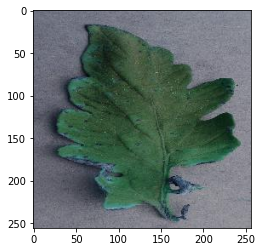

In [12]:
image = cv2.imread(veg_train_df.filepath[100])
imgplot = plt.imshow(image)
plt.show()

In [13]:
x_train = veg_train_df['filepath']
y_train = veg_train_df['label']

In [14]:
x_train_tensor = tf.convert_to_tensor(x_train.values, dtype=tf.string)
y_train_tensor = tf.convert_to_tensor(y_train.values)

In [15]:
TEST_PATH = "/content/Veg-dataset/test_set"

VEG_TEST_CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(TEST_PATH + "*/*"))])
VEG_TEST_CLASS_NAMES

array(['Tomato___Bacterial_spot', 'Tomato___Late_blight',
       'Pepper,_bell___healthy', 'Tomato___Leaf_Mold',
       'Potato___Early_blight', 'Tomato___Septoria_leaf_spot',
       'Potato___healthy', 'Pepper,_bell___Bacterial_spot',
       'Potato___Late_blight'], dtype='<U29')

In [16]:
files_test_count = []
for i,f in enumerate(VEG_TEST_CLASS_NAMES):
    folder_test_path = os.path.join(TEST_PATH, f)
    for path in os.listdir(os.path.join(folder_test_path)):
        files_test_count.append(['{}/{}'.format(folder_test_path,path), f, i])
veg_test_df = pd.DataFrame(files_test_count, columns=['filepath', 'class_name', 'label'])
veg_test_df.head()

,filepath,class_name,label
0,/content/Veg-dataset/test_set/Tomato___Bacteri...,Tomato___Bacterial_spot,0
1,/content/Veg-dataset/test_set/Tomato___Bacteri...,Tomato___Bacterial_spot,0
2,/content/Veg-dataset/test_set/Tomato___Bacteri...,Tomato___Bacterial_spot,0
3,/content/Veg-dataset/test_set/Tomato___Bacteri...,Tomato___Bacterial_spot,0
4,/content/Veg-dataset/test_set/Tomato___Bacteri...,Tomato___Bacterial_spot,0


In [17]:
veg_test_df.class_name.value_counts()

Tomato___Bacterial_spot          667
Tomato___Late_blight             599
Pepper,_bell___healthy           448
Tomato___Septoria_leaf_spot      421
Tomato___Leaf_Mold               322
Pepper,_bell___Bacterial_spot    317
Potato___Early_blight            300
Potato___Late_blight             290
Potato___healthy                  52
Name: class_name, dtype: int64

In [18]:
quantidade_por_class = 50
veg_test_df = pd.concat([veg_test_df[veg_test_df['class_name']== i][:quantidade_por_class] for i in VEG_TEST_CLASS_NAMES])

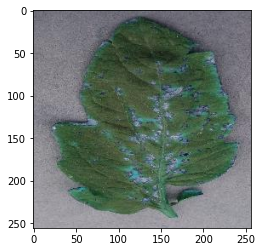

In [19]:
image = cv2.imread(veg_test_df.filepath[40])
imgplot = plt.imshow(image)
plt.show()

In [20]:
x_test = veg_test_df['filepath']
y_test = veg_test_df['label']

In [21]:
x_test_tensor = tf.convert_to_tensor(x_test.values, dtype=tf.string)
y_test_tensor = tf.convert_to_tensor(y_test.values)

In [22]:
train_data = tf.data.Dataset.from_tensor_slices((x_train_tensor, y_train_tensor))
test_data = tf.data.Dataset.from_tensor_slices((x_test_tensor, y_test_tensor))

In [23]:
def map_fn(path, label):
    image = tf.image.decode_jpeg(tf.io.read_file(path))
    return image, label
#apply the function
train_data_img = train_data.map(map_fn)
test_data_img = test_data.map(map_fn)

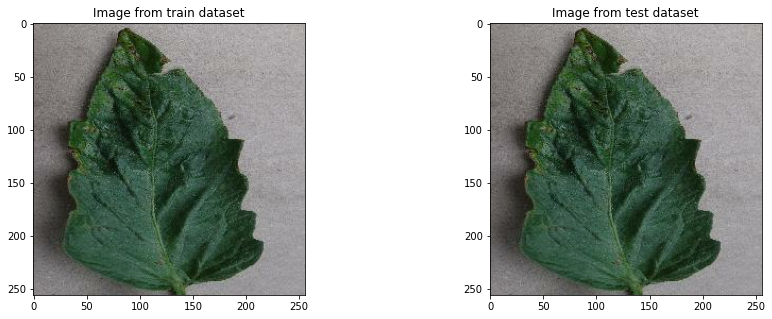

In [27]:
fig, ax = plt.subplots(1,2, figsize = (15,5))
for i,l in train_data_img.take(1):
    ax[0].set_title('Image from train dataset');
    ax[0].imshow(i);
for i,l in test_data_img.take(1):
    ax[1].set_title('Image from test dataset');
    ax[1].imshow(i);

In [25]:
def preprocessing(image, label):
    """
    returns a image that is reshaped and normalized
    """
    image = tf.cast(image, tf.float32)
    image = image / 255.
    image = tf.image.resize(image, IMAGE_SIZE)
    
    return image, label


train_data_norm = train_data_img.map(preprocessing)
test_data_norm = test_data_img.map(preprocessing)

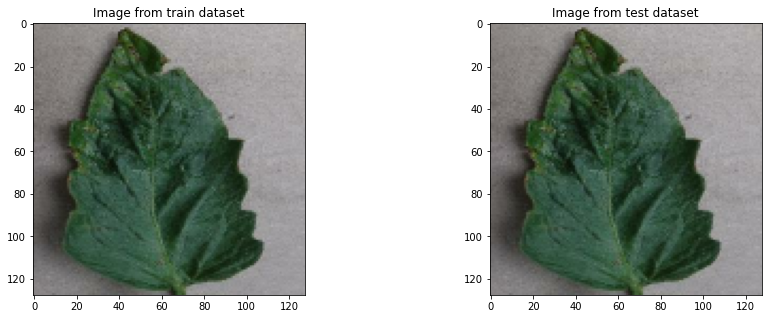

In [26]:
fig, ax = plt.subplots(1,2, figsize = (15,5))
for i,l in train_data_norm.take(1):
    ax[0].set_title('Image from train dataset');
    ax[0].imshow(i);
for i,l in test_data_norm.take(1):
    ax[1].set_title('Image from test dataset');
    ax[1].imshow(i);

In [28]:
train_batches = train_data_norm.batch(batch_size)
test_batches = test_data_norm.batch(batch_size)

for i, l in train_batches.take(1):
    print('Train Data Shape',i.shape)
for i, l in test_batches.take(1):
    print('Test Data Shape',i.shape)

Train Data Shape (32, 128, 128, 3)
Test Data Shape (32, 128, 128, 3)


In [30]:
LeNet = models.Sequential()
LeNet.add(layers.Conv2D(6, (5,5), activation = 'relu', input_shape = (128, 128, 3)))
LeNet.add(layers.AveragePooling2D())
LeNet.add(layers.Conv2D(16, (5,5), activation = 'relu'))
LeNet.add(layers.AveragePooling2D())
LeNet.add(layers.Flatten())
LeNet.add(layers.Dense(255, activation='relu'))
LeNet.add(layers.Dropout(0.2))
LeNet.add(layers.Dense(124, activation='relu'))
LeNet.add(layers.Dropout(0.2))
LeNet.add(layers.Dense(84, activation='relu'))
LeNet.add(layers.Dense(43, activation='sigmoid'))
LeNet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 124, 124, 6)       456       
                                                                 
 average_pooling2d_2 (Averag  (None, 62, 62, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_3 (Conv2D)           (None, 58, 58, 16)        2416      
                                                                 
 average_pooling2d_3 (Averag  (None, 29, 29, 16)       0         
 ePooling2D)                                                     
                                                                 
 flatten_1 (Flatten)         (None, 13456)             0         
                                                                 
 dense_4 (Dense)             (None, 255)              

In [32]:
LeNet.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [33]:
history = LeNet.fit(train_batches, epochs=100,batch_size = 16,validation_data=(test_batches))

Epoch 1/100
43/43 [==============================] - 28s 622ms/step - loss: 4.3473 - accuracy: 0.0881 - val_loss: 3.6458 - val_accuracy: 0.1111
Epoch 2/100
43/43 [==============================] - 27s 638ms/step - loss: 3.4292 - accuracy: 0.0533 - val_loss: 2.9212 - val_accuracy: 0.1111
Epoch 3/100
43/43 [==============================] - 28s 655ms/step - loss: 2.8959 - accuracy: 0.0281 - val_loss: 2.5286 - val_accuracy: 0.1111
Epoch 4/100
43/43 [==============================] - 28s 655ms/step - loss: 2.5744 - accuracy: 0.0652 - val_loss: 2.9001 - val_accuracy: 0.1111
Epoch 5/100
43/43 [==============================] - 26s 616ms/step - loss: 2.8948 - accuracy: 0.0089 - val_loss: 2.2549 - val_accuracy: 0.1111
Epoch 6/100
43/43 [==============================] - 26s 617ms/step - loss: 2.5526 - accuracy: 0.0496 - val_loss: 2.3275 - val_accuracy: 0.1111
Epoch 7/100
43/43 [==============================] - 26s 614ms/step - loss: 2.4069 - accuracy: 0.0363 - val_loss: 2.2637 - val_accuracy:

In [34]:
def process_image(path):
    img = tf.image.decode_image(tf.io.read_file(path))
    img = tf.cast(img, tf.float32)
    img = img / 255.
    img = tf.image.resize(img, IMAGE_SIZE)
    img_tensor = tf.convert_to_tensor(img)
    img_tensor = tf.expand_dims(img, axis=0)
    return img_tensor

In [35]:
image_pred = process_image(x_test.iloc[102])
#prediction = LeNet.predict_classes(image_pred)[0]
prediction = np.argmax(LeNet.predict(image_pred),axis=1)

print(("The image is a " + str(VEG_TEST_CLASS_NAMES[prediction[0]])).capitalize())
print(f'The image is predicted as a {VEG_TEST_CLASS_NAMES[y_test.iloc[102]]}')

1/1 [==============================] - 0s 177ms/step
The image is a pepper,_bell___healthy
The image is predicted as a Pepper,_bell___healthy
